## X-learner
X-learner is a Meta-algorithm by [künzel et al. (2018)](https://www.pnas.org/content/116/10/4156) 
that estimates heterogeneous treatment effect using five base-learners. Two are used for estimating the outcome (one for the treated and one for the non treated) Additional two are used to regress over the imputed treatment effect (again one for the treated cases and another for the non-treated). The fifth is used to estimate the propensity score of each case that is used to average the two regressed values.

***
$\mathbf{\text{X-learner(X, A, Y)}}$  
***

Learn the outcome estimators:   
&emsp;1.$ \hat\mu_{0}=M_{1}(Y\vert_{A=0} \sim X\vert_{A=0}) $  
&emsp;2.$ \hat\mu_{1}=M_{2}(Y\vert_{A=1} \sim X\vert_{A=1})  $  
&emsp;Implemented in causallib using a single T-learner (`StratifiedStandardization`) $ \hat\mu=M(Y \sim X) $  

Impute the predicted factual outcome with the actual observed outcome (but leave the counterfactual outcome prediction as is)  
&emsp;3. $ \tilde{Y}^1_{i} = A \cdot Y_{i} + (1-A) \cdot \mu_{1}(X_i) $  
&emsp;4. $ \tilde{Y}^0_{i} = (1-A) \cdot Y_{i} + A \cdot \mu_{0}(X_i) $   

Calculate the imputed treatment effect:  
&emsp;5. $ D_{i} = \tilde{Y}^1_{i} - \tilde{Y}^0_{i}$   
&emsp;Note that there may be other possible contrasts than the effect difference, like risk-ratio (using `effect_types`).

Regress over the treatment effect:   
&emsp;6. $ \hat\tau_0 = M_{3}(D\vert_{A=0} \sim X\vert_{A=0}) $  
&emsp;7. $ \hat\tau_1 = M_{4}(D\vert_{A=1} \sim X\vert_{A=1}) $  
&emsp;Note that this as well is a T-learner, and is implemented in causallib using a single T-learner (`StratifiedStandardization`) $ \hat\tau=M(D \sim X) $  

Fit a treatment prediction model   
&emsp;8. $ g = M_{5}(A \sim X) $   

Average the CATE according to the propensity:  
&emsp;9. $ \hat\tau(X_i) = g(X_i)\hat\tau_0(X_i) + (1-g(X_i))\hat\tau_1(X_i) $  
***


We can see that the "X" from "X-learner" comes from the imputation of factual outcome predictions, 
so the effect crosses between the observed outcome of the treated with the counterfactual prediction under no-treatment (and vice-versa).  
It's interesting to note that the estimation steps use common building blocks from causal modeling.
While the paper describes four machine-learning models ($M_1,...,M_4$), 
these are actually two T-learners (a causal model that trains one prediction for the treated and another for the control).
And so, naturally, since all we need is a model that takes $X$ and $A$ and outputs counterfactual predictions, we can, in theory, also use an S-learner when applicable (and might enjoy better power, which T-learner lacks since it is a completely un-pooled model).  
In the language of causallib, this means you can either use `Standardization` or `StratifiedStandaridzation` (or any `IndividualOutcomeEstimator`, even `TMLE`) and plug in whatever machine-learning estimator you'd like.

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import time
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
from causallib.datasets import load_nhefs
from causallib.evaluation import OutcomeEvaluator
from causallib.estimation import StratifiedStandardization, Standardization, XLearner
warnings.filterwarnings("ignore")
%matplotlib inline

### Revisiting the NHEFS data set

We are going to analyze the National Health and Nutrition Examination Survey (NNHEFS) dataset and analyze it using the X-learner. 
If focuses on smoking habits and contains general demographic data of participants, whether they stopped-smoking, and their weight at the start of the study (1971) and at the end of it (1983) (more info: [[1]](https://causallib.readthedocs.io/en/latest/causallib.datasets.data_loader.html#causallib.datasets.data_loader.load_nhefs) [[2]](https://github.com/IBM/causallib/blob/master/examples/nhefs.ipynb)). 

#### Xlearner training
The "Vanilla" X-learner algorithm is obtained by initializing the Xlearner estimator with two `StratifiedStandardization` (one for the outcome and one for the effect estimation aka CATE). But as mentioned we will use a `Standardization` model for the effect. 
This is will allow us to later explore model explainability with [SHAP](https://shap.readthedocs.io/en/latest/index.html). 

In [2]:
data = load_nhefs()
xlearner = XLearner(
            outcome_model=StratifiedStandardization(GradientBoostingRegressor()),
            effect_model=Standardization(GradientBoostingRegressor()),
            effect_types='diff'
        )
_ = xlearner.fit(data['X'],data['a'],data['y'])
effect = xlearner.estimate_effect(data['X'],data['a'],agg='population') # 
print(f"{effect["diff"]:.6f}")

diff    3.465171
dtype: float64


Now let's see what would have been the result if we only used the `StratifiedStandardization` model (namely, the first step of X-learner without the later imputation and effect modelling).

In [3]:
outcomes = xlearner.outcome_model.estimate_individual_outcome(data['X'],data['a'],predict_proba=True)
print(f"{outcomes[1]-outcomes[0]:.6f}")

3.444814

We see the two results result are very comparable with the one another in this relatively simple case.

### Explaining the effect estimation
We can now extract the gradient-boosting trees underlying the `StratifiedStandardization` outcome model.  
We can further display their average feature importance using Shapley values, to provide an explanation (for information about SHAP, see [[1]](https://shap.readthedocs.io/en/latest/index.html) [[2]](https://en.wikipedia.org/wiki/Shapley_value)).
Since the target variable in the first step is the outcome, this is similar to applying SHAP on a usual machine learning task (only that we have two such models), and querying the importance of charachteristics in predicting weight-change.

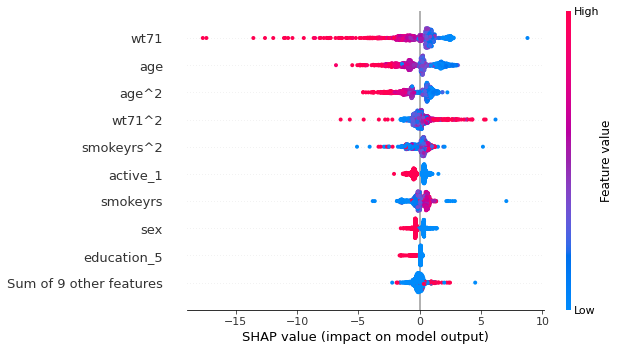

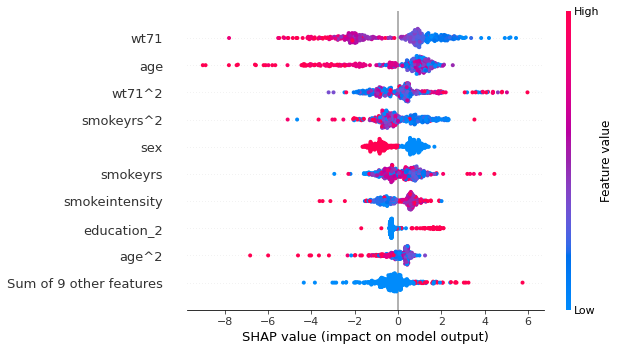

In [4]:
for treatment in [0,1]:
    model = xlearner.outcome_model.learner[treatment]
    X = data['X'].loc[ data['a']==treatment,:]
    explainer = shap.Explainer(model,X)
    shap_values = explainer(X)
    shap.plots.beeswarm(shap_values)
    plt.gca().set_title(f"Treatment: {treatment}")

We can easily see that age and weight-at-baseline (`wt71`) are the most important features. 
First, the older the participants the greater their reduction in weight over the years, which can be explain by basic physiology with loss of muscle and bone density.
Second, the higher the weight at baseline the greater the weight-loss, which can actually be explained by a simple regression-to-the-mean - heavier participants loss weight, while thinner participants gained weight on average.  
However, remember these are the changes in the outcome, not the effect. 

Note that we used a `StaratifiedStanrdardization` for obtaining a heterogeneous treatment effect, but two models mean two sets of feature importances. 
Therefore, we have some consolidation to make regarding the different importances of the same features in the two treatment groups. 
To overcome this, we use a single model (`Standardization`) when explaining the effect.

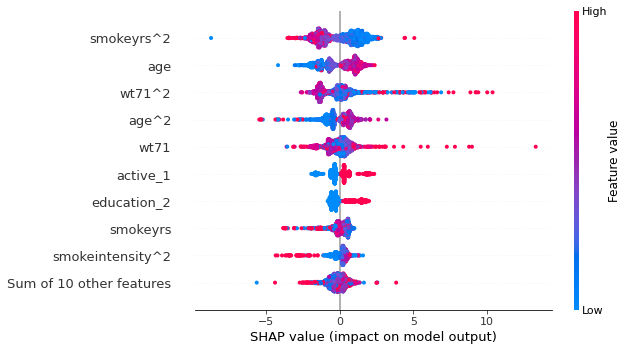

In [5]:
model = xlearner.effect_model.learner
X = xlearner.effect_model._prepare_data(data['X'],data['a'])
explainer = shap.Explainer(model,X)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values)

Here we see the picture for age and weigh-at-baseline is less clear than when predicting the outcome.
We can see that by the greater overlap of different Feature Values \[colors\] on the impact on prediction \[x-axis\]).
However, we can see that older participants had larger increase in weights if quitting, relative to younger particpants. 
So we can say that the earlier participants quit the larger the reduction in weight.  
Additionally, we now see education level and activity are more clearly associated with heterogeneity of weight reduction, probably as a proxy for a more healthy-aware lifestyle.

We do see, that while sex had a clear and realtively-strong effect on the outcome,
it has relatively little impact on modifying the effect of smoking cessation.

#### Effect estimator error
We still need to keep in mind the error of the effect estimator. If the effect regressor is close to random we might assume that the effect model did not estimate the causal effect. Some measure of error is accepted, the ground truth is also an estimation of the effect and might be less accurate then the calculates by the effect model.

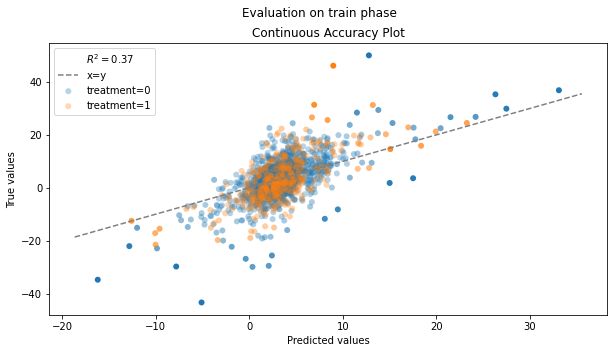

In [7]:
# Select the cate model
effect_model_evaluator = OutcomeEvaluator(xlearner.effect_model)
# the `effect_model` estimates the imputed treatment effect (see rows five and six in the algorithm description)
imputed_effects = xlearner._estimate_imputed_treatment_effect(data['X'],data['a'],data['y'])
effect_results = effect_model_evaluator.evaluate_simple(data['X'],data['a'],imputed_effects,plots=["continuous_accuracy"])
effect_results.plots['continuous_accuracy'].get_figure().set_size_inches(10,5)  # Reduce figure size

### Warm start ###
We can use the warm start feature to reduce run time. 
If an effect estimator is not given in the constructor, `Xlearner` copies it from the outcome estimator. 
The copy is preformed post-fit, so warm starting the effect estimator with the outcome is applicable.   
We would like to use this if the base model takes a lot of time to train and if the effect estimation is a similar to outcome estimation. For example we might use a neural network with iterative optimization process, it is possible that starting the effect-estimation-network with the final weights of the outcome-network will shorten the training time. 

To test the time reduction, we will use the simulated data from the X-learner paper.

Keep in mind that "warm start" is a broad term, in it varies between different types of machine learning models.
In optimizing weight-based base-estimators such as neural network, it is define the starting point for the optimization process, while in some trees ensembles it can be creating a copy the entire ensemble without additional training. 

In [2]:
def _generate_X(n, d, seed=0):
    rng = np.random.RandomState(seed)
    sigma = np.array([[0.7**(np.abs(i-j)) for i in range(d)]
                      for j in range(d)])
    X = pd.DataFrame(rng.multivariate_normal(np.zeros(d), sigma, size=n))
    return X
    
def generate_data_SI1(n=500, d=20, seed=0, treat_fraction=0.02):
    '''
    Simulation SI1 - linear response and imbalanced treatment assignment
    '''
    rng = np.random.RandomState(seed)
    X = _generate_X(n, d, seed)
    a = pd.Series(rng.binomial(1, treat_fraction, n))
    
    beta = rng.uniform(-5, 5, size=(d,))    
    mu_0 = np.dot(X, beta) + 5 * np.array(X.iloc[:, 0]>0.5)
    mu_1 = mu_0 + 8 * np.array(X.iloc[:, 1]>0.1)
    tau = mu_1 - mu_0 
    y = a * mu_1 + (1-a) * mu_0 + rng.normal(size=(n,))
    return {"X": X, "a": a, "y": y, "tau": tau, 'mu_0':mu_0, 'mu_1':mu_1}


# we create the data set here so we could accurately compare the run time. 
sim_data = generate_data_SI1(n=50000, d=20, seed=0)

In [9]:
start = time.time()
xlearner_cold = XLearner(
            outcome_model=StratifiedStandardization(MLPRegressor()),
            effect_types='diff'
        )
_ = xlearner_cold.fit(sim_data['X'],sim_data['a'],sim_data['y'])
end = time.time()
effect = xlearner_cold.estimate_effect(sim_data['X'],sim_data['a'],agg='population')
print('Calculated ATE: {:.3f} Actual ATE: {:.3f}'.format(effect.head().values[0],sim_data['tau'].mean()))
print('Run time (seconds): {:.2f}'.format(end - start))

Calculated ATE: 3.731 Actual ATE: 3.661
Run time (seconds): 54.67


In [10]:
start = time.time()
xlearner_warm = XLearner(
            outcome_model=StratifiedStandardization(MLPRegressor(warm_start=True)),
            effect_types='diff'
        )
_ = xlearner_warm.fit(sim_data['X'],sim_data['a'],sim_data['y'])
end = time.time()
effect = xlearner_warm.estimate_effect(sim_data['X'],sim_data['a'],agg='population') 
print('Calculated ATE: {:.3f} Actual ATE: {:.3f}'.format(effect.head().values[0],sim_data['tau'].mean()))
print('Run time (seconds): {:.2f}'.format(end - start))

Calculated ATE: 4.161 Actual ATE: 3.661
Run time (seconds): 26.19


The training time was halved yet the results were less accurate. Given more adaptive training schemes could give more accurate results.

### X-learner vs. T-learner

Künzel et al. claim that X-learner is superior to T-learner and S-learner in imbalanced settings, and in balanced settings - X-learner is superior to S-learner when the treated and control groups differ.
Here below we extended the authors' analysis in comparing X-learner with T-learner under varying treatment imbalances,
using the same simulated data from the paper.  
To examine the exact impact of the second-step modeling of the effect, the T-learner we'll use will be the first-step outcome model from the X-learner itself.

We will measure the error in effect estimation - both the bias relative to the average treatment effect (ATE) and the error of the heterogeneous (PEHE [[Hill 2011]](https://www.tandfonline.com/doi/abs/10.1198/jcgs.2010.08162), which is basically the RMSE of the individual effect estimation), and R-sqaured.

In [3]:
results = pd.DataFrame(index=range(9),columns=['Actual ATE','StratifiedStandardization ATE','Xlearner ATE','Xlearner R squared','StratifiedStandardization R squared',
'Xlearner mse','StratifiedStandardization mse'])
for i,fr in enumerate(np.arange(0.02,0.51,0.06)):
    sim_data = generate_data_SI1(n=5000, d=20, seed=56,treat_fraction=fr)
    xlearner_ds = XLearner(
                outcome_model=StratifiedStandardization(GradientBoostingRegressor()),
                effect_types='diff'
            )
    _ = xlearner_ds.fit(sim_data['X'],sim_data['a'],sim_data['y'])
    #effect = xlearner_ds.estimate_effect(sim_data['X'],sim_data['a'],agg='population')
    xlearner_effect = xlearner_ds.estimate_effect(sim_data['X'],sim_data['a'],agg='individual')
    tlearner_effect = xlearner_ds.outcome_model.estimate_individual_outcome(sim_data['X'],sim_data['a'],predict_proba=True)
    tlearner_effect = tlearner_effect[1] - tlearner_effect[0]
    results.loc[i,'Xlearner ATE'] = xlearner_effect.mean()
    results.loc[i,'StratifiedStandardization ATE'] = tlearner_effect.mean()
    results.loc[i,'Actual ATE'] = sim_data['tau'].mean()
    results.loc[i,'Xlearner R squared'] = r2_score(sim_data['tau'], xlearner_effect)
    results.loc[i,'StratifiedStandardization R squared'] = r2_score(sim_data['tau'], tlearner_effect)
    results.loc[i,'Xlearner PEHE'] = mean_squared_error(sim_data['tau'], xlearner_effect, squared=False)
    results.loc[i,'StratifiedStandardization PEHE'] = mean_squared_error(sim_data['tau'], tlearner_effect, squared=False)


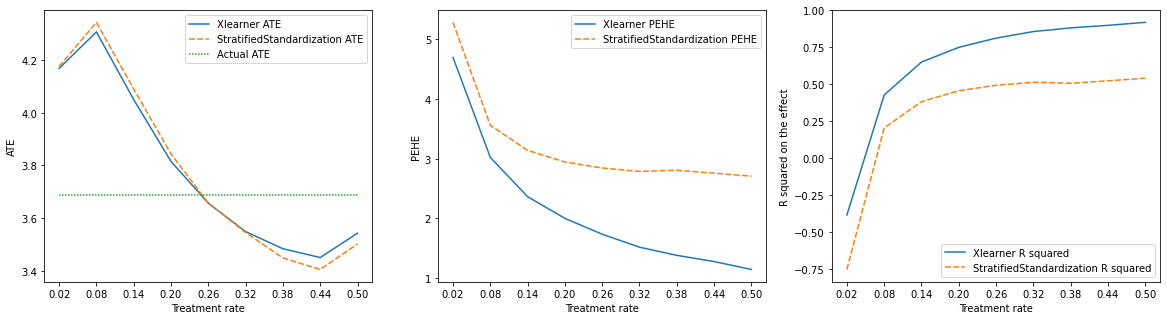

In [4]:
f,(ax1,ax2,ax3) = plt.subplots(1,3)
ax1 = sns.lineplot(data=results[['Xlearner ATE','StratifiedStandardization ATE','Actual ATE']],ax=ax1)
ax1.set_ylabel('ATE')
ax2 = sns.lineplot(data=results[['Xlearner PEHE','StratifiedStandardization PEHE']],ax=ax2)
ax2.set_ylabel('PEHE')
ax3 = sns.lineplot(data=results[['Xlearner R squared','StratifiedStandardization R squared']],ax=ax3)
ax3.set_ylabel('R squared on the effect')
for ax in [ax1,ax2,ax3]:
    ax.set_xlabel('Treatment rate')
    _ = ax.set_xticklabels(['{:.2f}'.format(v) for v in np.arange(0.02,0.51,0.06)])
    _ = ax.set_xticks(range(9))
f.set_size_inches(20,5)

Looking at the left panel, we can see that X-learner does have smaller bias than T-learner throughout all treatment prevalences. So adding the extra X-learner steps does not damage the T-learner in terms of average treatment effect.
It does have consistently better PEHE performance, suggesing it also better at estimating heterogeneous effect estimation.